In [7]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [13]:
import os
import gzip
import numpy as np
from PIL import Image as Img

In [14]:
from fastai import *
from fastai.vision import *

In [15]:
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

In [16]:
def load_mnist(path, kind='train'): # for test pass in t10k
    """Load MNIST data from `path`"""
    if kind == 'valid':
        kind = 't10k'

    labels_path = os.path.join(path, f'{kind}-labels-idx1-ubyte.gz')
    images_path = os.path.join(path, f'{kind}-images-idx3-ubyte.gz')

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8, offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

In [17]:
label_dict = {
 0: "T-shirt/top",
 1: "Trouser",
 2: "Pullover",
 3: "Dress",
 4: "Coat",
 5: "Sandal",
 6: "Shirt",
 7: "Sneaker",
 8: "Bag",
 9: "Ankle boot"
}

output_path = "../../../../fashion_mnist_data"
if not os.path.exists(output_path):
    os.makedirs(output_path)
    for dataset in ['train', 'valid']:
        os.makedirs(os.path.join(output_path, dataset))
        for value in label_dict.values():
            os.makedirs(os.path.join(output_path, dataset, value))

data_path = "../../../../fashion-mnist/data/fashion/"
for dataset in ['train', 'valid']:
    print(f"Processing for dataset {dataset}")
    images, labels = load_mnist(data_path, dataset)
    images = np.reshape(images, (images.shape[0], 28, 28))
    for k in label_dict.keys():
        print(f"writing images for class {label_dict[k]}")
        i = labels == k
        images_subset = images[i]
        for i in range(images_subset.shape[0]):
            im = Img.fromarray(images_subset[i])
            dest_image_path = os.path.join(output_path,
                                           dataset,
                                           label_dict[k],
                                           "".join([str(i), ".png"]))
            im.save(dest_image_path)

Processing for dataset train
writing images for class T-shirt/top
writing images for class Trouser
writing images for class Pullover
writing images for class Dress
writing images for class Coat
writing images for class Sandal
writing images for class Shirt
writing images for class Sneaker
writing images for class Bag
writing images for class Ankle boot
Processing for dataset valid
writing images for class T-shirt/top
writing images for class Trouser
writing images for class Pullover
writing images for class Dress
writing images for class Coat
writing images for class Sandal
writing images for class Shirt
writing images for class Sneaker
writing images for class Bag
writing images for class Ankle boot


In [18]:
tfms = get_transforms()
path = "../../../../fashion_mnist_data/"
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=28)
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList
y: CategoryList (60000 items)
[Category Coat, Category Coat, Category Coat, Category Coat, Category Coat]...
Path: ../../../../fashion_mnist_data
x: ImageItemList (60000 items)
[Image (3, 28, 28), Image (3, 28, 28), Image (3, 28, 28), Image (3, 28, 28), Image (3, 28, 28)]...
Path: ../../../../fashion_mnist_data;

Valid: LabelList
y: CategoryList (10000 items)
[Category Coat, Category Coat, Category Coat, Category Coat, Category Coat]...
Path: ../../../../fashion_mnist_data
x: ImageItemList (10000 items)
[Image (3, 28, 28), Image (3, 28, 28), Image (3, 28, 28), Image (3, 28, 28), Image (3, 28, 28)]...
Path: ../../../../fashion_mnist_data;

Test: None

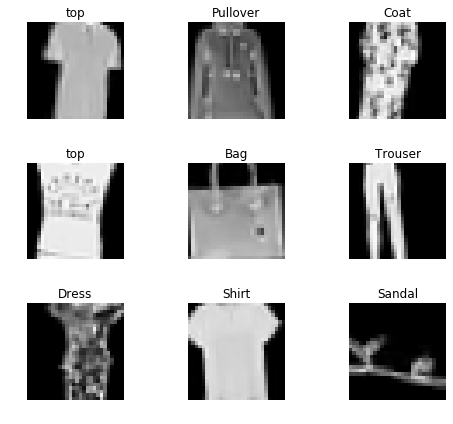

In [19]:
data.show_batch(rows=3, figsize=(7,6))

In [20]:
learn = create_cnn(data, models.resnet50, metrics=error_rate)
learn.fit_one_cycle(20)

epoch,train_loss,valid_loss,error_rate
1,1.060026,0.766428,0.269300
2,0.856486,0.646182,0.234000
3,0.703590,0.557155,0.208400
4,0.631008,0.478272,0.177100
5,0.543435,0.428196,0.159000
6,0.526677,0.387348,0.145500
7,0.490239,0.375022,0.142400
8,0.453162,0.348802,0.131100
9,0.428861,0.330485,0.124500
10,0.410437,0.315555,0.117700


In [21]:
learn.save('fashion-stage-1')

In [22]:
interp = ClassificationInterpretation.from_learner(learn)

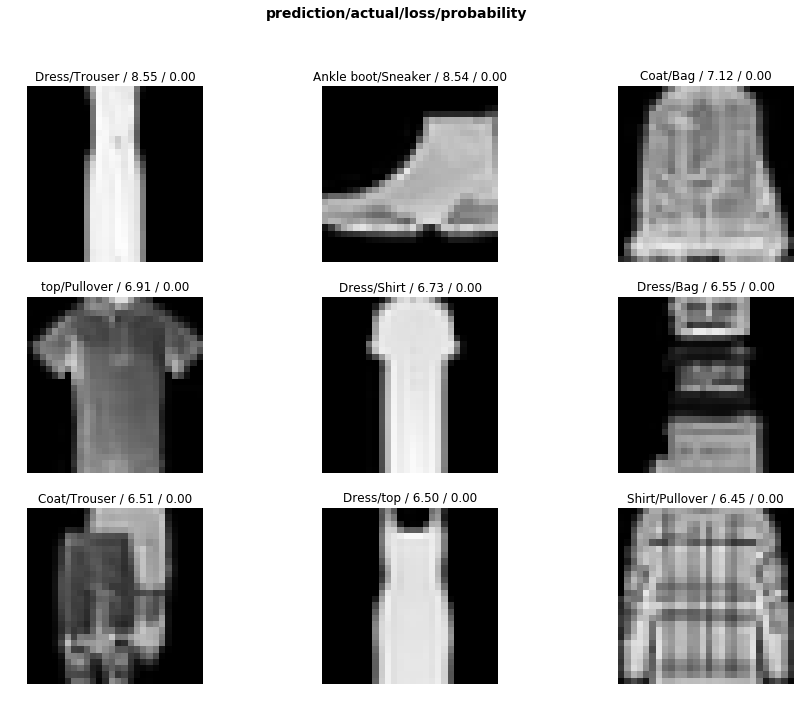

In [23]:
interp.plot_top_losses(9, figsize=(15,11))

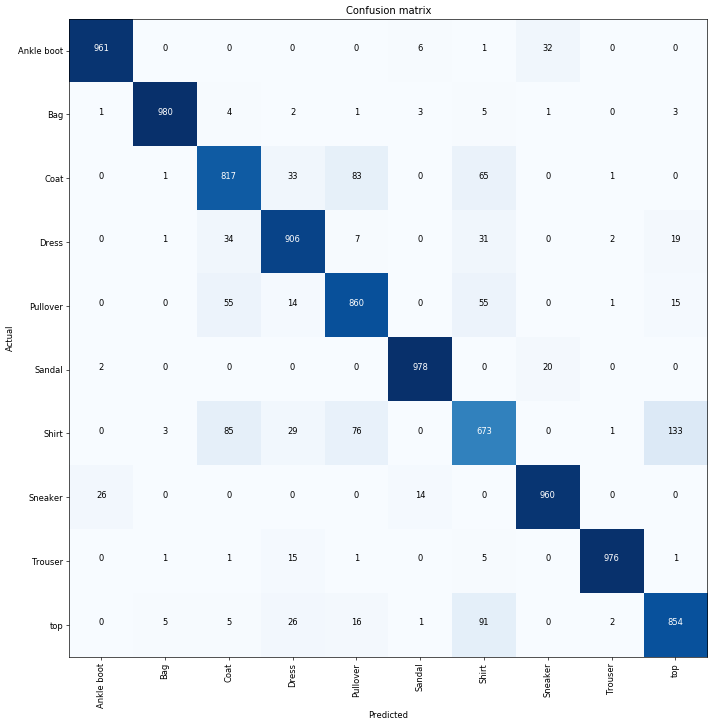

In [24]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [25]:
interp.most_confused(min_val=2)

[('Shirt', 'top', 133),
 ('top', 'Shirt', 91),
 ('Shirt', 'Coat', 85),
 ('Coat', 'Pullover', 83),
 ('Shirt', 'Pullover', 76),
 ('Coat', 'Shirt', 65),
 ('Pullover', 'Coat', 55),
 ('Pullover', 'Shirt', 55),
 ('Dress', 'Coat', 34),
 ('Coat', 'Dress', 33),
 ('Ankle boot', 'Sneaker', 32),
 ('Dress', 'Shirt', 31),
 ('Shirt', 'Dress', 29),
 ('Sneaker', 'Ankle boot', 26),
 ('top', 'Dress', 26),
 ('Sandal', 'Sneaker', 20),
 ('Dress', 'top', 19),
 ('top', 'Pullover', 16),
 ('Pullover', 'top', 15),
 ('Trouser', 'Dress', 15),
 ('Pullover', 'Dress', 14),
 ('Sneaker', 'Sandal', 14),
 ('Dress', 'Pullover', 7),
 ('Ankle boot', 'Sandal', 6),
 ('Bag', 'Shirt', 5),
 ('Trouser', 'Shirt', 5),
 ('top', 'Bag', 5),
 ('top', 'Coat', 5),
 ('Bag', 'Coat', 4),
 ('Bag', 'Sandal', 3),
 ('Bag', 'top', 3),
 ('Shirt', 'Bag', 3)]

In [26]:
learn.unfreeze()

In [27]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,error_rate
1,0.440406,0.412158,0.153800
2,0.323647,0.280499,0.107200
3,0.278504,0.241518,0.090100


In [31]:
learn.load('fashion-stage-1')

In [32]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


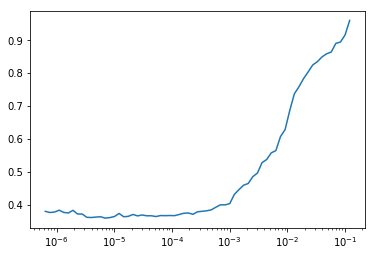

In [33]:
learn.recorder.plot()

In [34]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

Total time: 01:33
epoch  train_loss  valid_loss  error_rate
1      0.374034    0.285815    0.105778    (00:46)
2      0.354199    0.278710    0.102222    (00:46)



In [12]:
import matplotlib.pyplot as plt

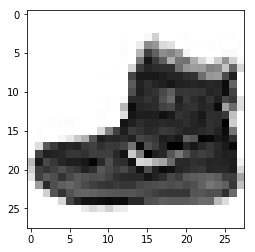

In [14]:
plt.imshow(images[0,:,:], cmap='Greys')

In [24]:
from collections import Counter
freq = Counter(readable_labels)